<h1> Amazon Apparel Recommendations </h1>



### Overview of the data

In [0]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### [9.6] Weighted similarity using brand and color.

In [0]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [0]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

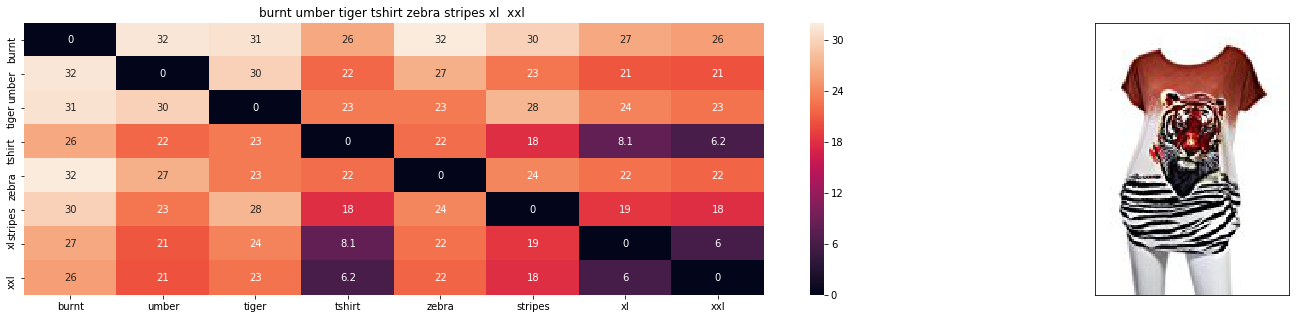

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.001953125


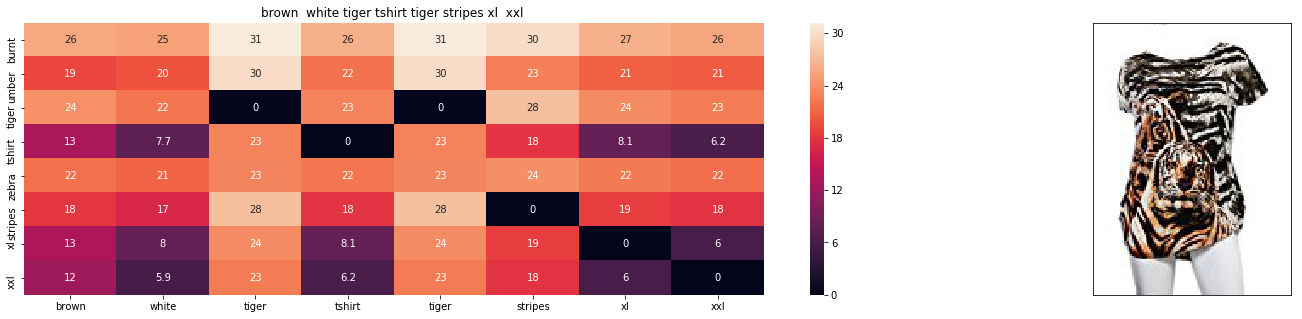

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 2.38547115326


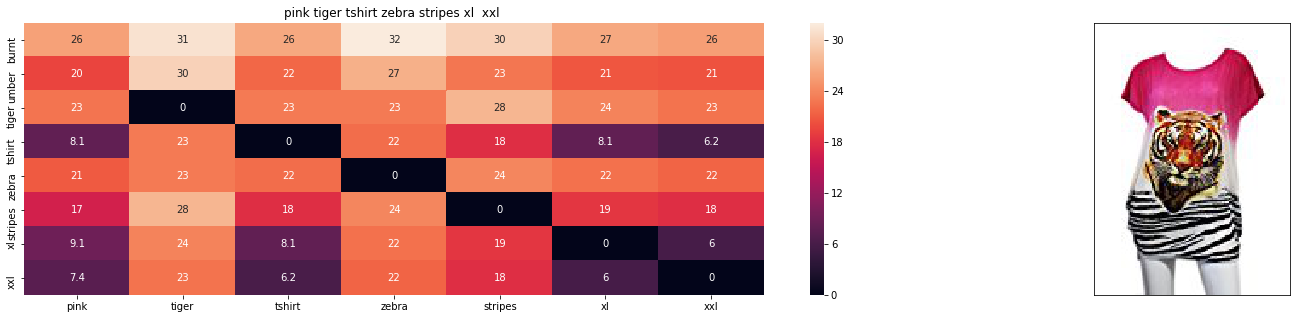

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 2.73905105609


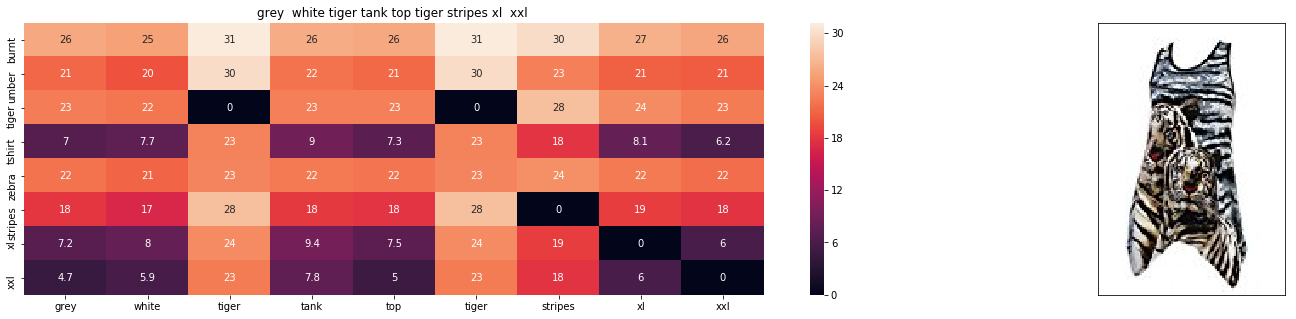

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 3.387187195


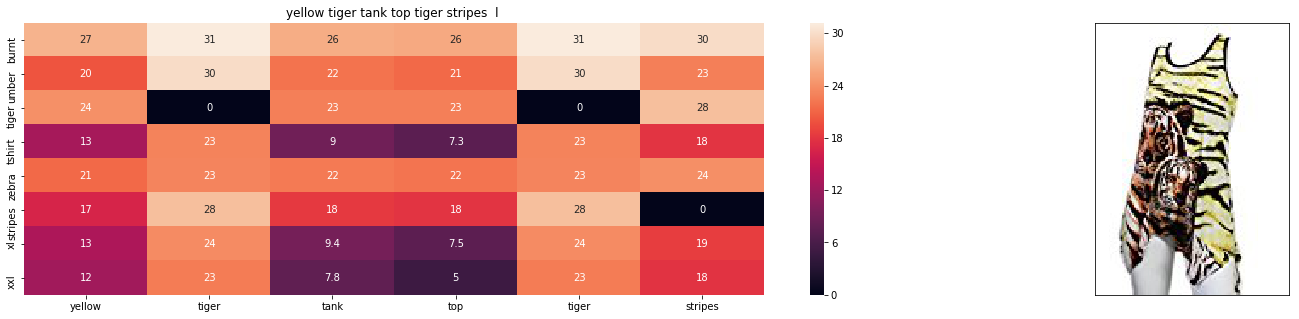

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 3.5518684389


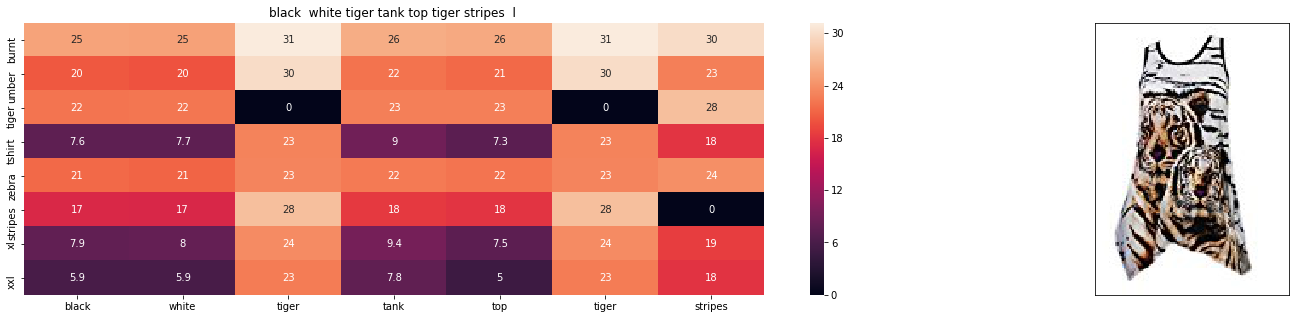

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 3.5536174776


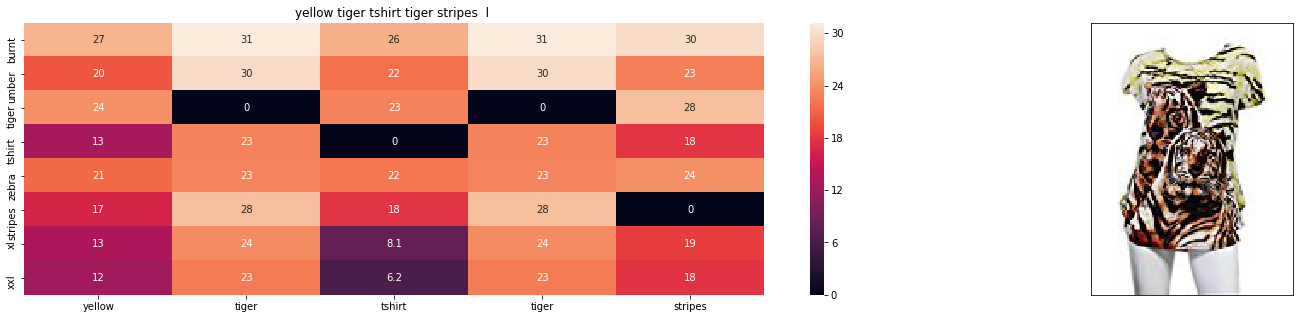

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 3.65382804889


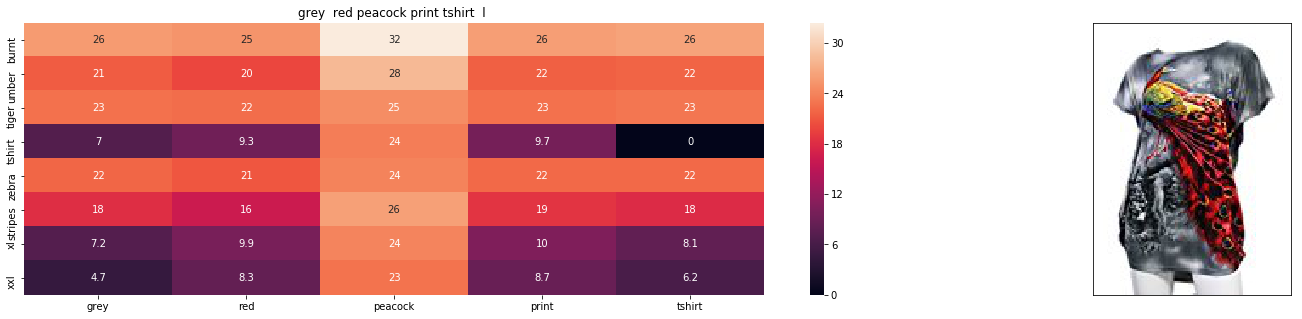

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 4.12881164569


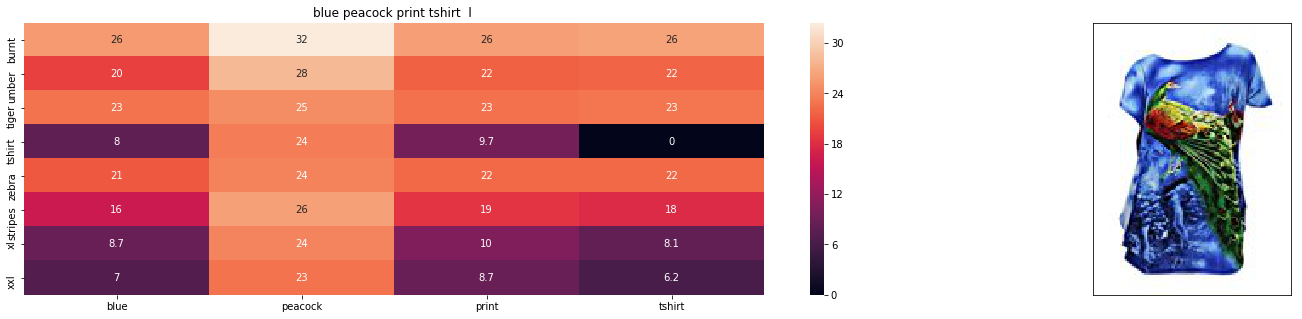

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 4.20390052813


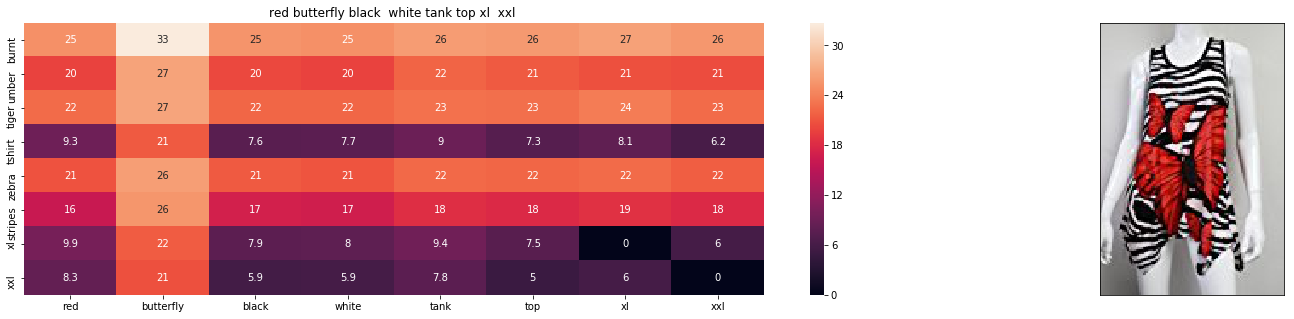

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 4.28658676166


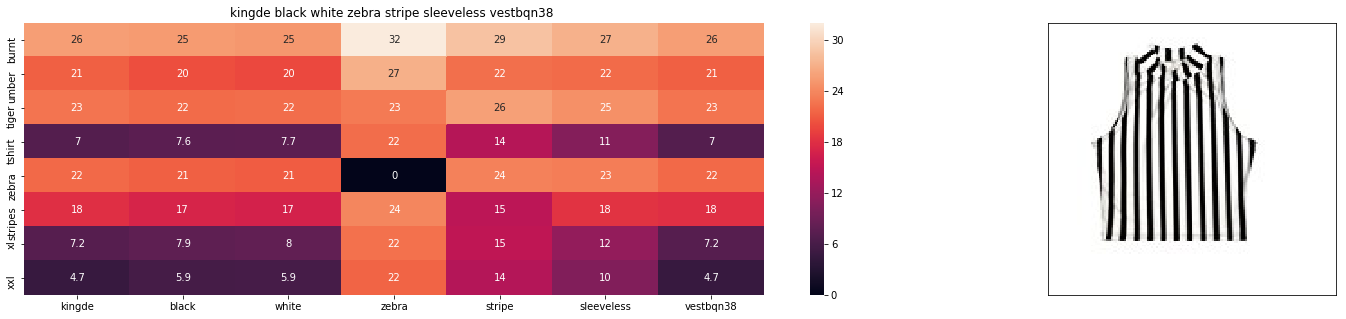

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 4.38937078798


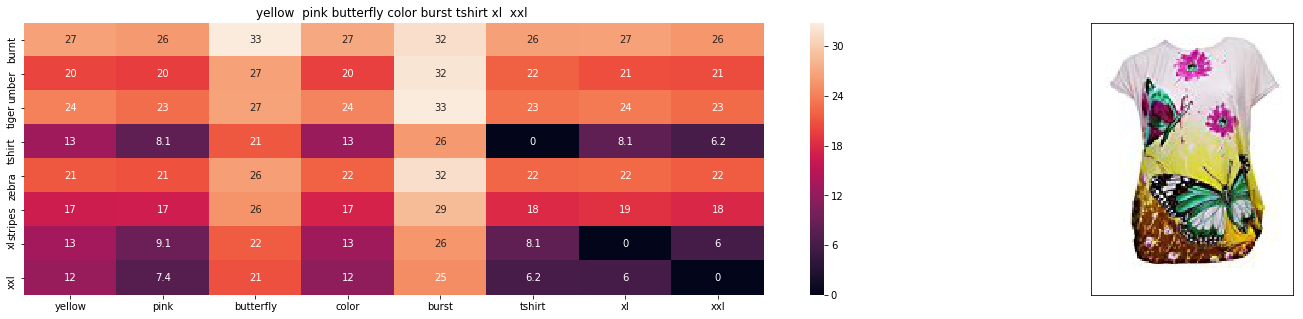

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 4.39790992755


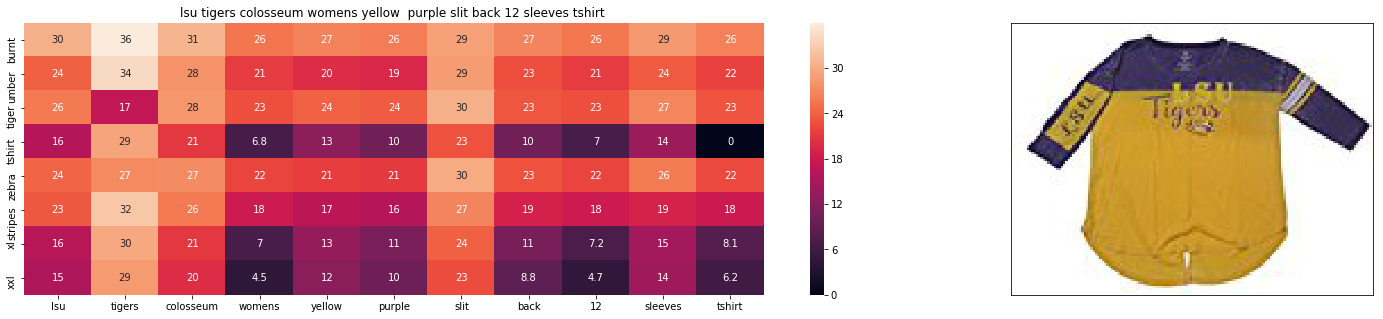

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 4.45122858369


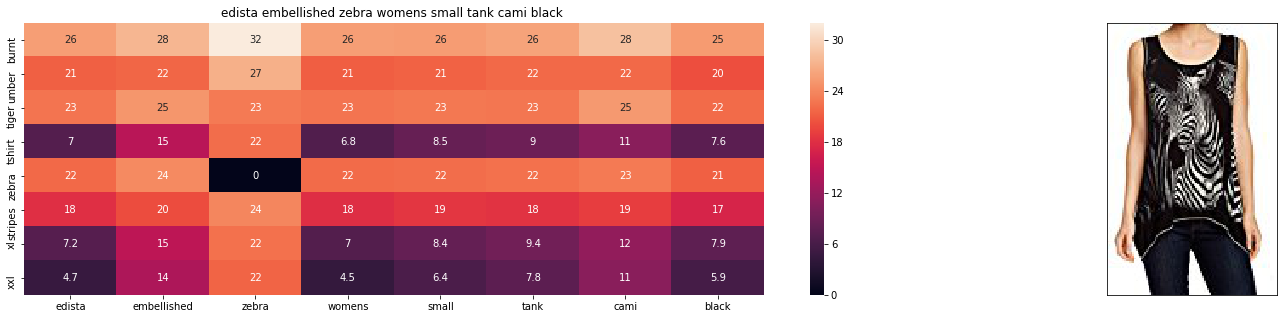

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 4.51897779787


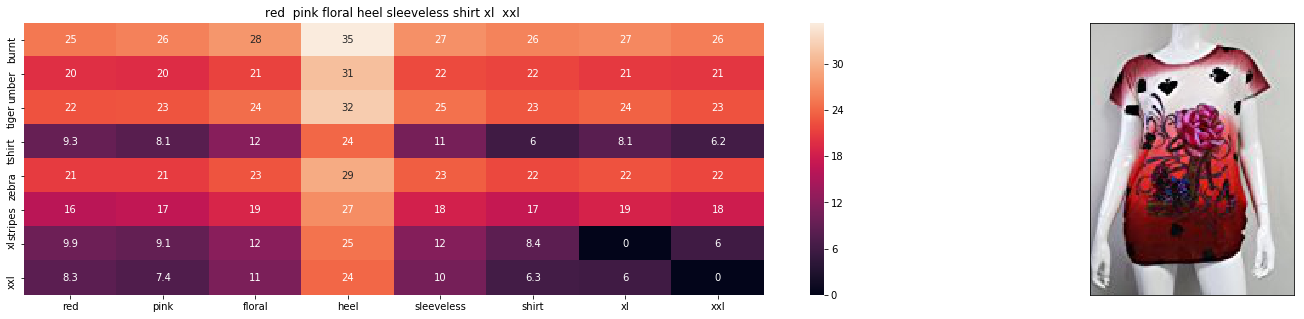

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 4.52937545794


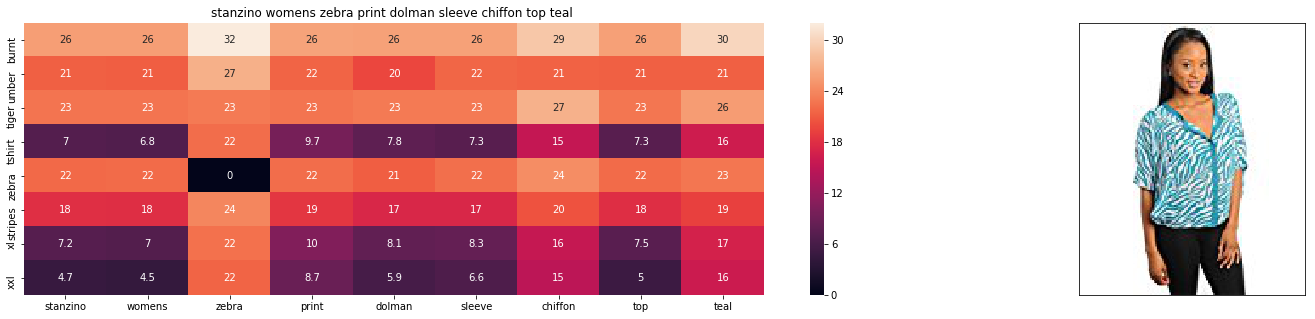

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 4.53032614076


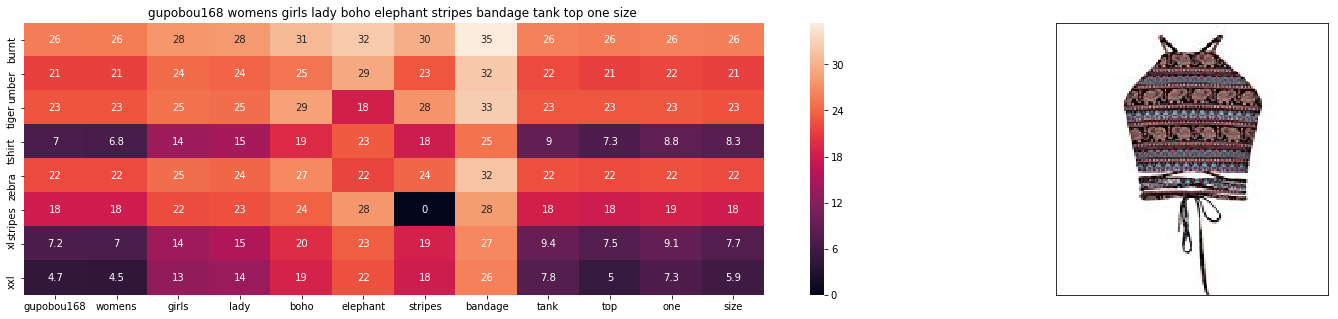

ASIN : B01ER184O6
Brand : GuPoBoU168
euclidean distance from input : 4.54681702403


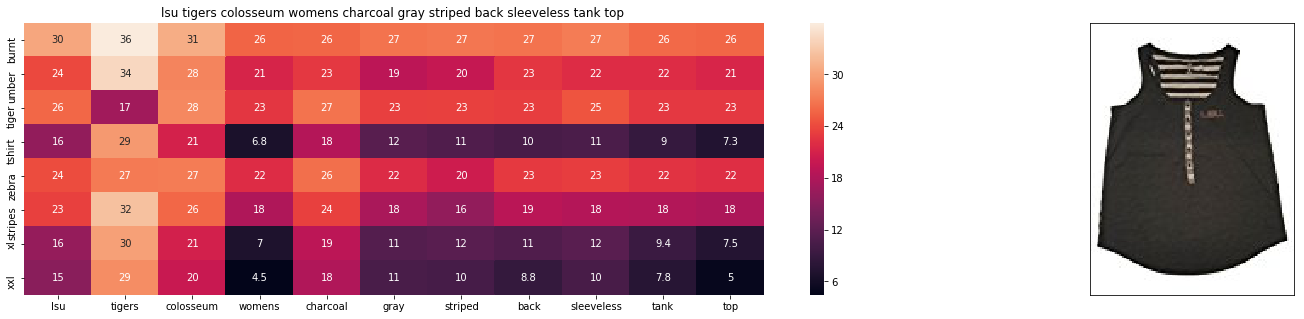

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 4.54835554445


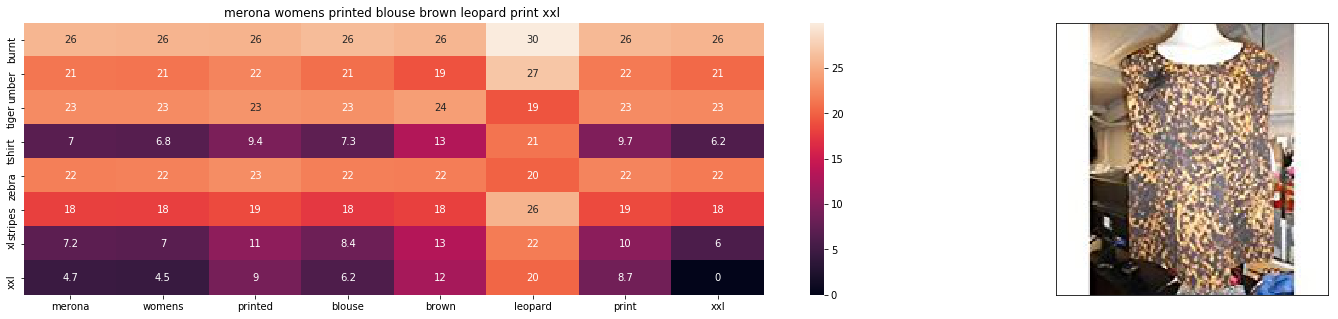

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 4.61062742555


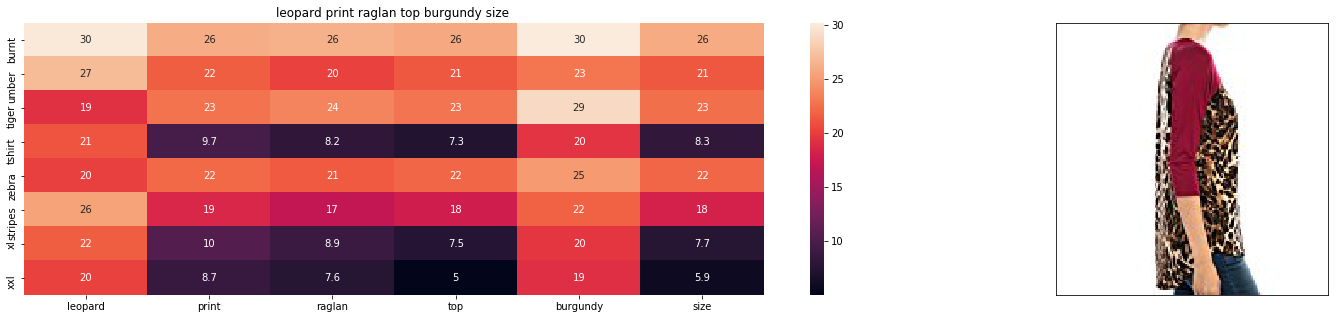

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 4.64591789282


In [0]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

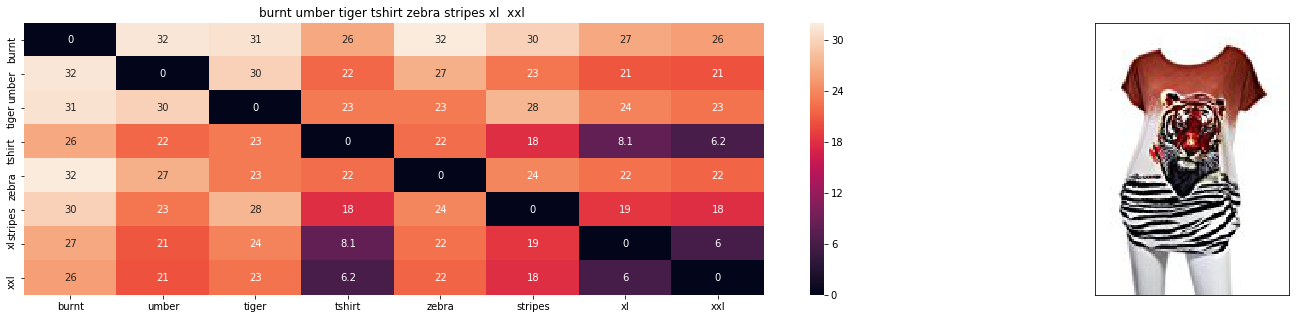

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.000355113636364


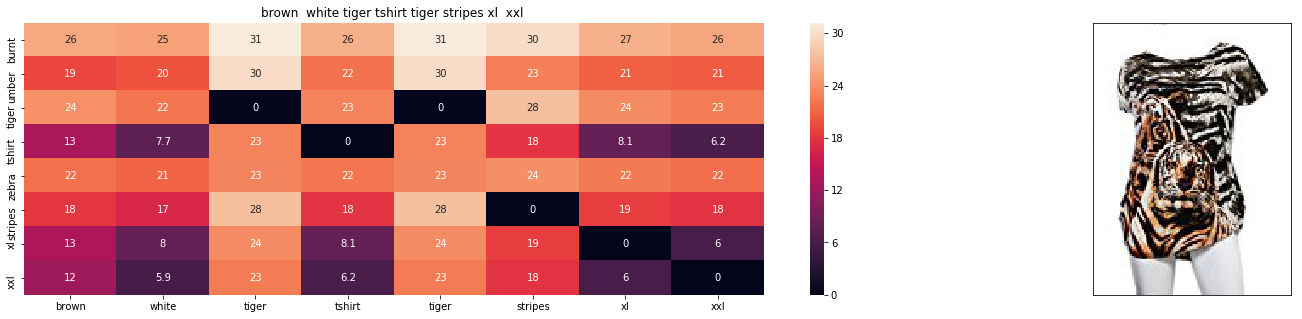

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 0.433722027865


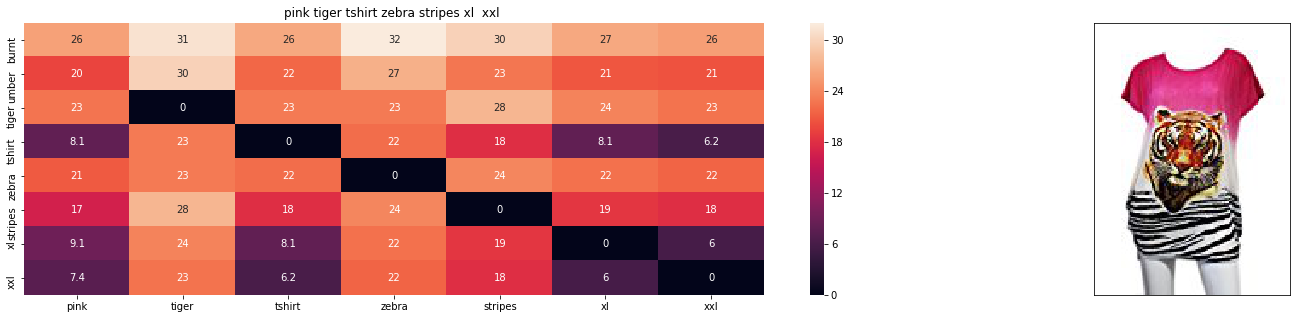

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 1.65509310669


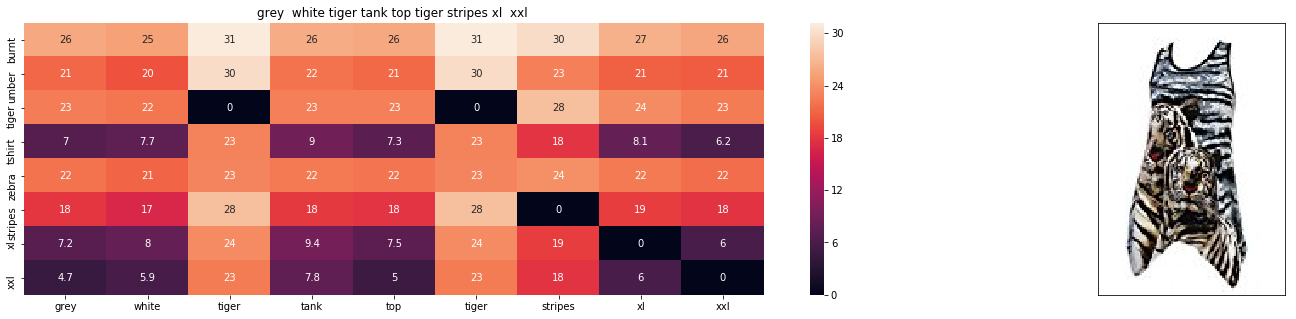

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 1.77293604103


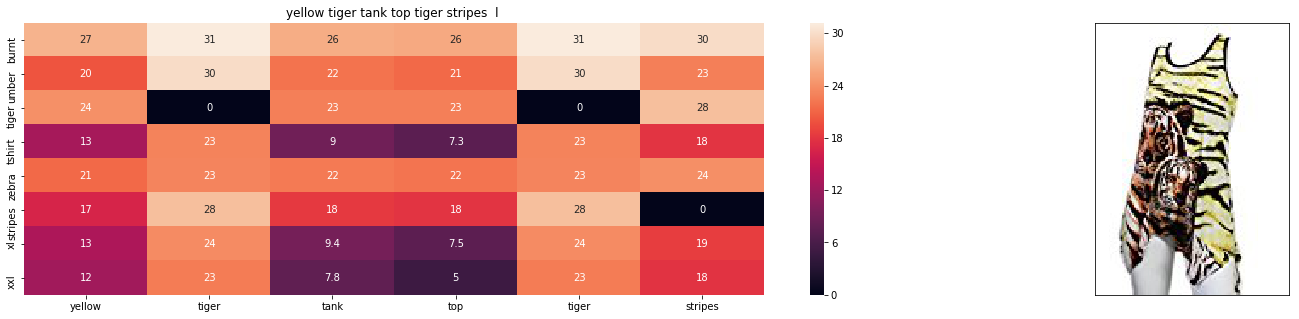

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 1.80287808538


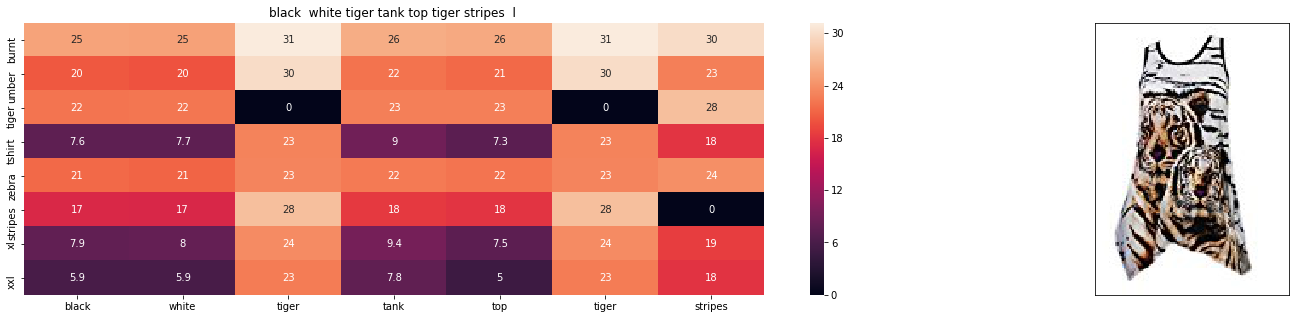

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 1.80319609241


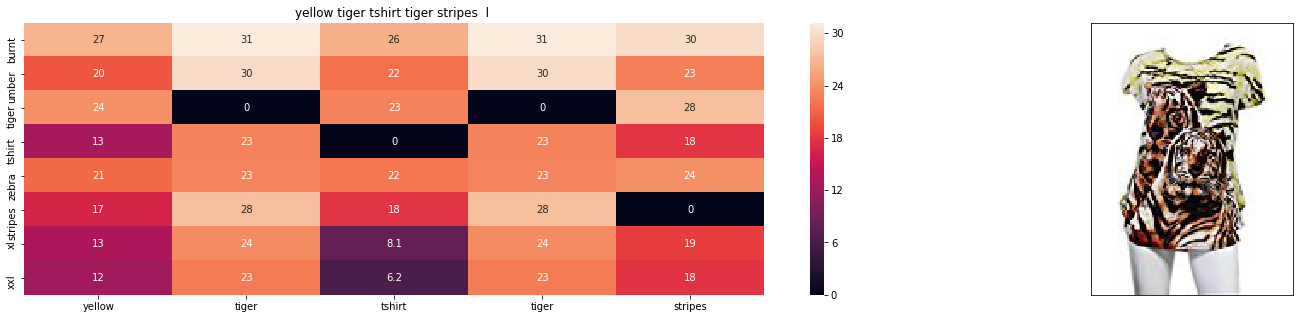

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 1.82141619628


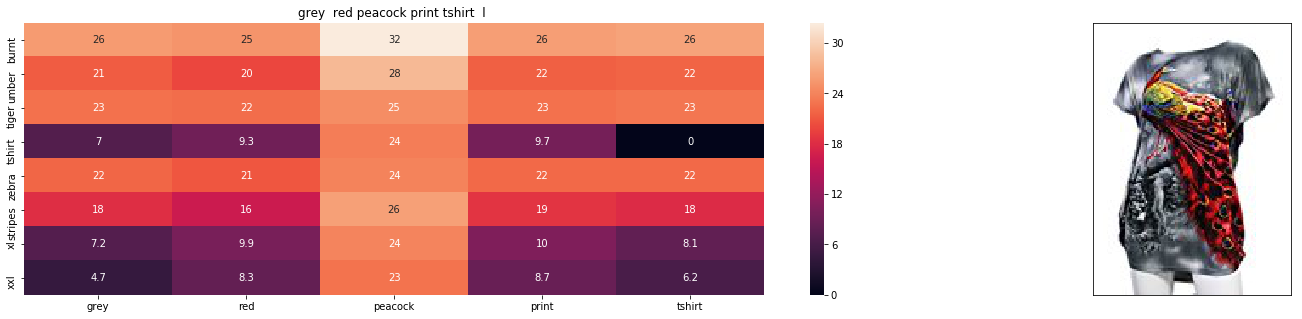

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 1.90777685025


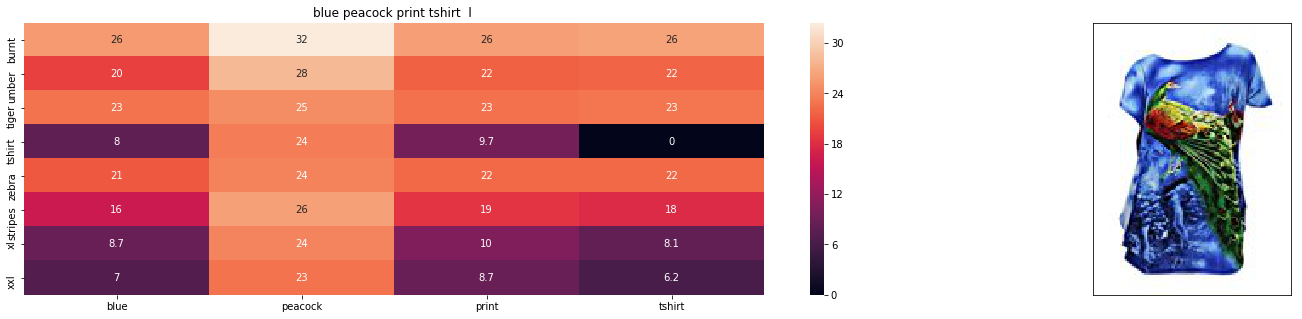

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 1.92142937433


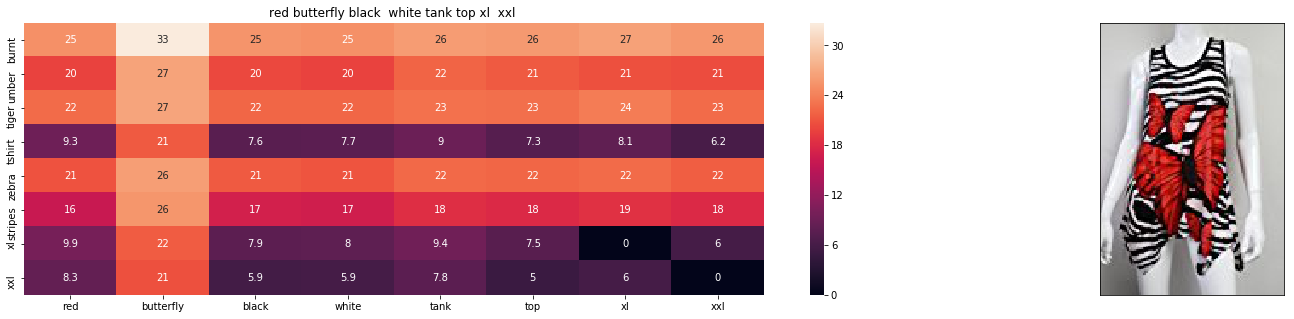

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 1.93646323497


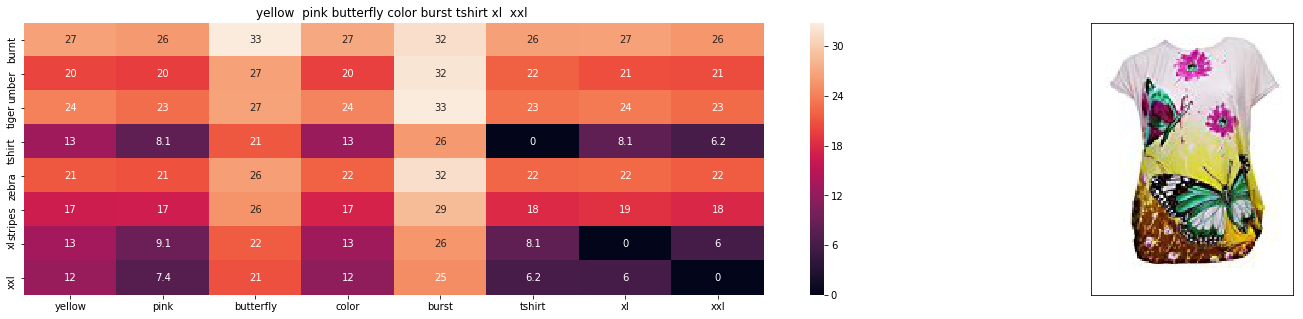

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 1.95670381059


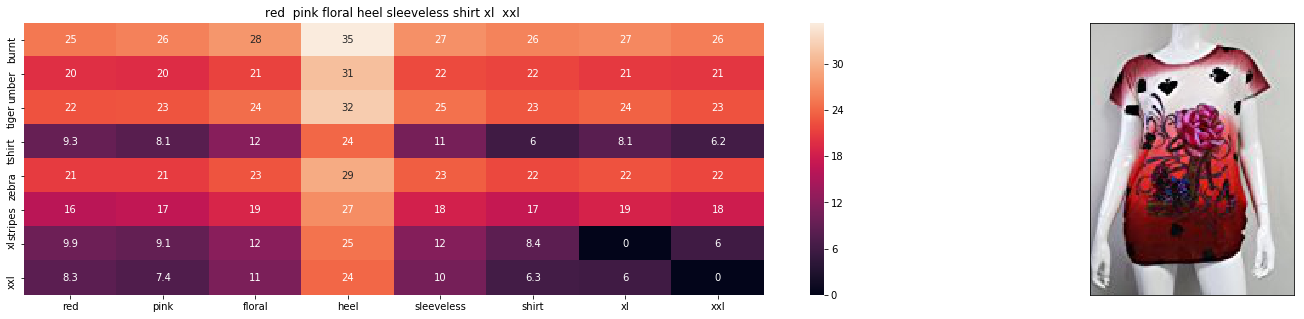

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 1.9806066343


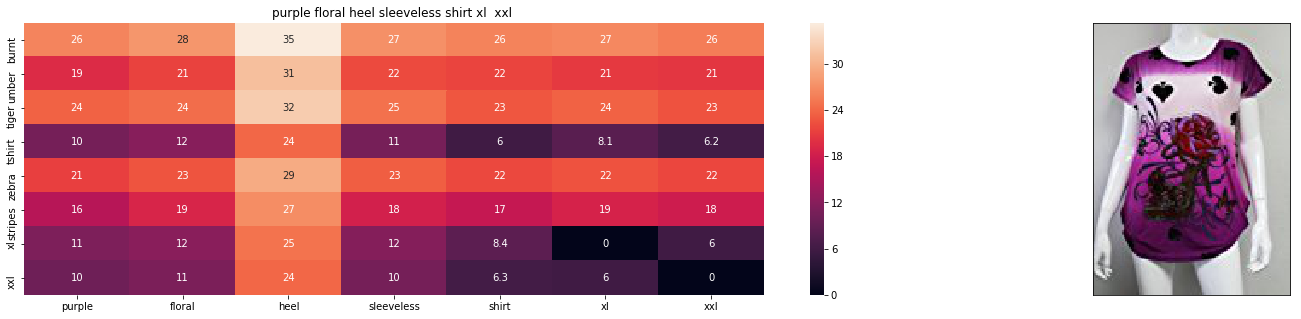

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from input : 2.01218559992


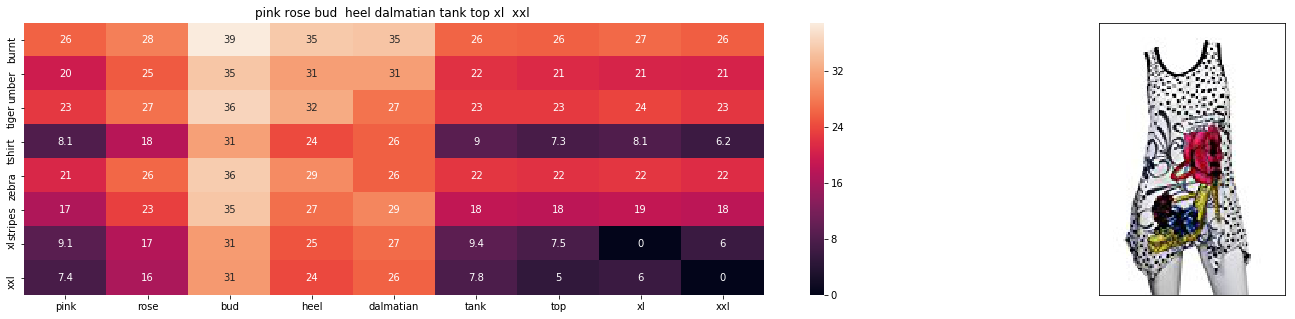

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from input : 2.01335178755


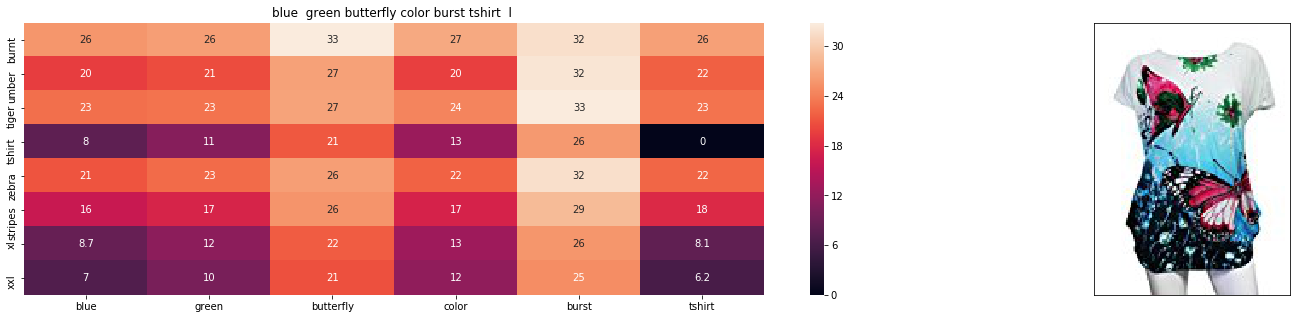

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from input : 2.01388334827


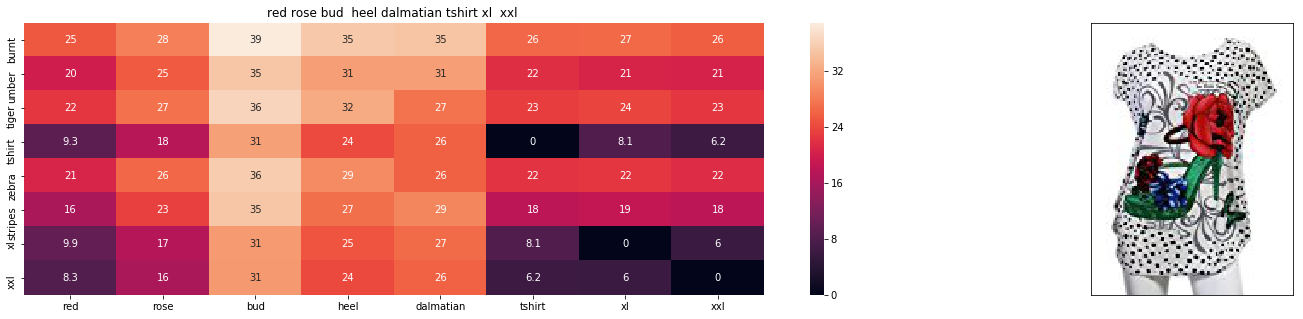

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from input : 2.0367257555


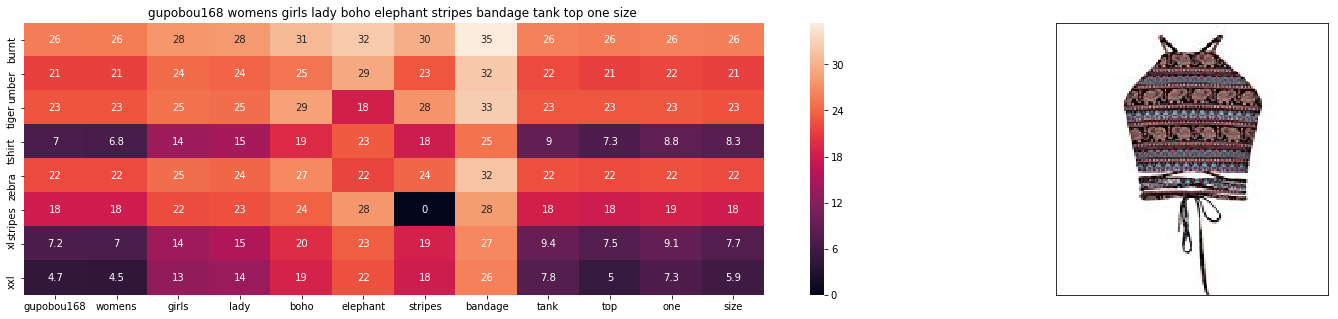

ASIN : B01ER184O6
Brand : GuPoBoU168
euclidean distance from input : 2.65620416778


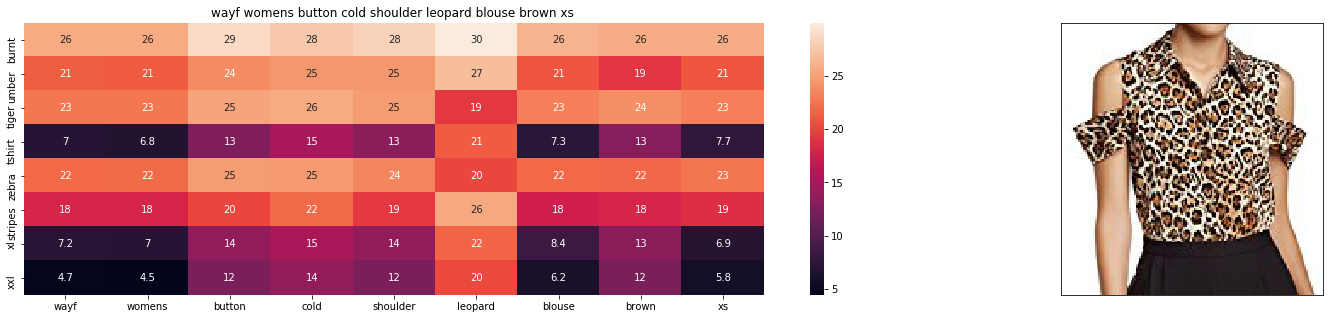

ASIN : B01LZ7BQ4H
Brand : WAYF
euclidean distance from input : 2.6849067823


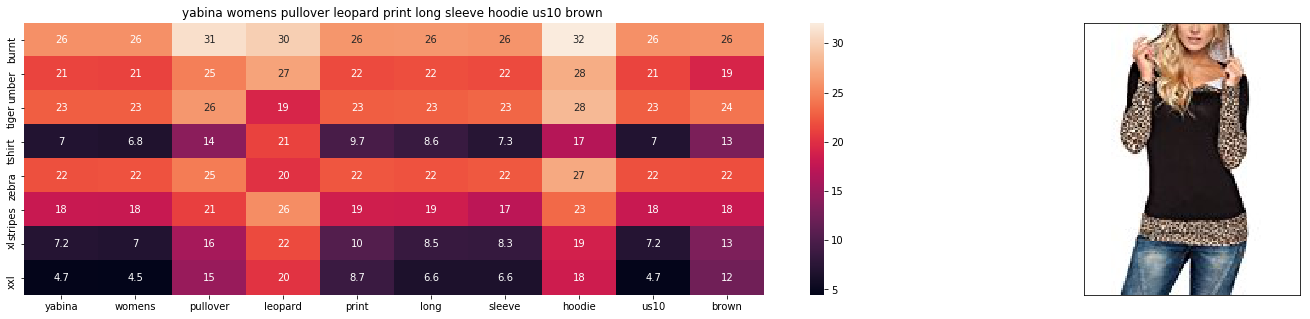

ASIN : B01KJUM6JI
Brand : YABINA
euclidean distance from input : 2.68583819266


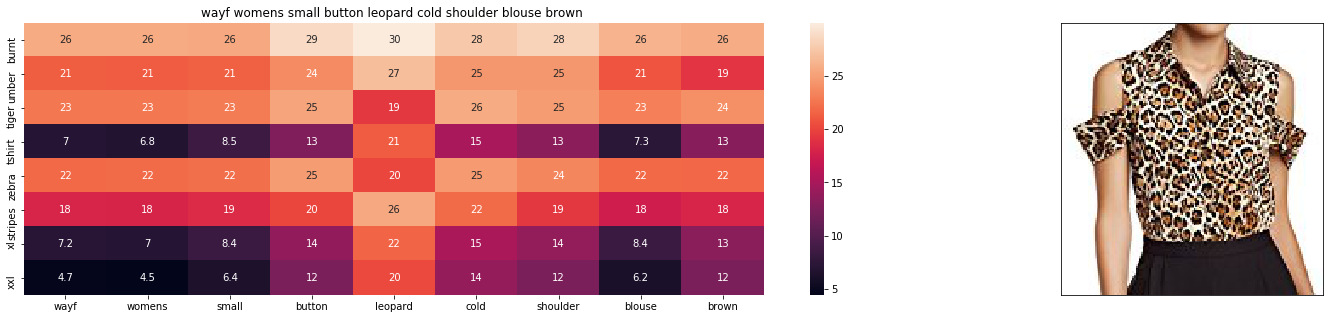

ASIN : B01M06V4X1
Brand : WAYF
euclidean distance from input : 2.69476194865


In [0]:
# brand and color weight =50
# title vector weight = 5

idf_w2v_brand(12566, 5, 50, 20)